# TUTORIAL: Multi-Label, Multi-Class Text Classification with BERT, Transformers and Keras

By Emil Lykke Jensen

**This tutorial is not exactly the same as we are doing with anomaly:**


*   He predicts a 'Product' and an 'Issue' label from each narrative. 

*   'Product' and 'Issue' have, each, several classes.

It's like we would predict 'Primary Problem' AND 'Anomaly' in AeroBOT.

It can be interesting to do this later on, but not yet, due to higher complexity.

[Article](https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a)


[Code](https://gist.github.com/emillykkejensen/aa7535c29538a956d5b9c41e31f731a1)


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.4 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
     |████████████████████████████████| 101 kB 11.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Import packages

In [ ]:
#######################################
### -------- Load libraries ------- ###

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split

# Import data

## Mount Google Drive


In [ ]:
## Mount GDrive

#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

Mounted at /content/drive/
/content/drive/MyDrive/data/transformed
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Read the data

In [ ]:
# I downloaded the data from this website
# https://www.consumerfinance.gov/data-research/consumer-complaints/search/?company_received_min=2019-12-31&date_received_max=2022-07-28&date_received_min=2022-04-30&has_narrative=true&page=1&searchField=all&size=25&sort=created_date_desc&tab=List
# using the filter to get the data of the last 2 months, i.e. approx 40,000 entries to limit the file size

In [ ]:
# Import data from csv
data = pd.read_csv('complaints-2022-08-05_13_55.csv')

# Select required columns
data = data[['Consumer complaint narrative', 'Product', 'Issue']]
# Consumer complaint narrative’ will serve as our input for the model 
# and ‘Product’ and ‘Issue’ as our two outputs.

# Remove a row if any of the three remaining columns are missing
data = data.dropna()

# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('Issue').filter(lambda x : len(x) > 1)
data = data.groupby('Product').filter(lambda x : len(x) > 1)

# Set your model output as categorical and save in new label col
data['Issue_label'] = pd.Categorical(data['Issue'])
data['Product_label'] = pd.Categorical(data['Product'])

# Transform your output to numeric
data['Issue'] = data['Issue_label'].cat.codes
data['Product'] = data['Product_label'].cat.codes

# Split into train and test - stratify over Issue
data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['Issue']])

# Setup BERT

## Select model and tokenizer

Here we first load a BERT config object that controls the model, tokenizer and so on.

Then, a tokenizer that we will use later in our script to transform our text input into BERT tokens and then pad and truncate them to our max length. The tokenizer is pretty well documented so I won’t get into that here.

Lastly, we will load the BERT model itself as a BERT Transformers TF 2.0 Keras model (here we use the 12-layer bert-base-uncased).

From [HuggingFace](https://huggingface.co/docs/transformers/model_doc/bert): 

BertConfig is the configuration class to store the configuration of a BertModel (Pytorch) or a TFBertModel (TensorFlow). It is used to instantiate a BERT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the BERT bert-base-uncased architecture.

Configuration objects inherit from PretrainedConfig and can be used to control the model outputs. Read the documentation from PretrainedConfig for more information.

In [ ]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 100

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# BertConfig is the configuration class to store the configuration 
# of a BertModel (Pytorch) or a TFBertModel (TensorFlow). It is used to 
# instantiate a BERT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the BERT bert-base-uncased architecture.

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Build the model

We are ready to build our model. In the Transformers library, there are a number of [different BERT classification models to use](https://huggingface.co/transformers/model_doc/bert.html). The mother of all models is the one simply called ‘BertModel’ (PyTorch) or ‘TFBertModel’ (TensorFlow) and thus the one we want.

The Transformers library also comes with a prebuilt BERT model for sequence classification called ‘[TFBertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification)’. If you take a look at the code found here (invalid link) you’ll see, that they start by loading a clean BERT model and then they simply add a dropout and a dense layer to it. Therefore, what we’ll do is simply to add two dense layers instead of just one.

Here's what our model looks like:

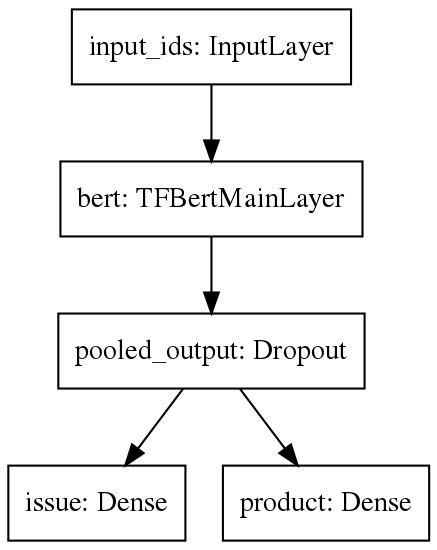

And a more detailed view of the model seen in the model.summary() below.

Now that we have our model architecture, all we need to do is write it in code.

In [ ]:
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
# attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
# inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
# There are two outputs in parallel: issue and product
issue = Dense(units=len(data.Issue_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
# Why don't we have any activation like sigmoid?

# Write the two outputs into a dictionary
outputs = {'issue': issue, 'product': product}

# Combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                               
                                 768),                                                            
                                 pooler_output=(Non                      

# Train

In [ ]:
# # /!\ takes 50min. to execute
# # See the LOAD command below to avoid re-training

# # Set an optimizer
# optimizer = Adam(
#     learning_rate=5e-05,
#     epsilon=1e-08,
#     decay=0.01,
#     clipnorm=1.0)

# # Set loss and metrics
# loss = {'issue': CategoricalCrossentropy(from_logits = True), 'product': CategoricalCrossentropy(from_logits = True)}
# metric = {'issue': CategoricalAccuracy('accuracy'), 'product': CategoricalAccuracy('accuracy')}

# # Compile the model
# model.compile(
#     optimizer = optimizer,
#     loss = loss, 
#     metrics = metric)

# # Ready output data for the model
# y_issue = to_categorical(data['Issue'])
# y_product = to_categorical(data['Product'])

# # Tokenize the input (takes some time)
# x = tokenizer(
#     text=data['Consumer complaint narrative'].to_list(),
#     add_special_tokens=True,
#     max_length=max_length,
#     truncation=True,
#     padding=True, 
#     return_tensors='tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     verbose = True)

# # Fit the model
# history = model.fit(
#     # x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
#     x={'input_ids': x['input_ids']},
#     y={'issue': y_issue, 'product': y_product},
#     validation_split=0.2,
#     batch_size=64,
#     epochs=10)

Epoch 1/10
419/419 [==============================] - 352s 792ms/step - loss: 2.3377 - issue_loss: 1.7067 - product_loss: 0.6310 - issue_accuracy: 0.5479 - product_accuracy: 0.8134 - val_loss: 1.7877 - val_issue_loss: 1.3602 - val_product_loss: 0.4275 - val_issue_accuracy: 0.6304 - val_product_accuracy: 0.8790
Epoch 2/10
419/419 [==============================] - 329s 785ms/step - loss: 1.6348 - issue_loss: 1.2650 - product_loss: 0.3698 - issue_accuracy: 0.6563 - product_accuracy: 0.8930 - val_loss: 1.6019 - val_issue_loss: 1.2279 - val_product_loss: 0.3740 - val_issue_accuracy: 0.6631 - val_product_accuracy: 0.8908
Epoch 3/10
419/419 [==============================] - 328s 784ms/step - loss: 1.4450 - issue_loss: 1.1385 - product_loss: 0.3066 - issue_accuracy: 0.6879 - product_accuracy: 0.9123 - val_loss: 1.5330 - val_issue_loss: 1.1765 - val_product_loss: 0.3565 - val_issue_accuracy: 0.6762 - val_product_accuracy: 0.8947
Epoch 4/10
419/419 [==============================] - 330s 787ms

# Save / Load the trained model

### Save

In [ ]:
# # save your fine-tuned model for later use
# import tensorflow as tf
# import keras
# %cd /content/drive/MyDrive/data/saved models/
# saved_model_path = './Tutorial_Jensen_BERT_model_20220806/' 
# model.save(saved_model_path, include_optimizer= True) # creates a new folder

# # More information:
# # https://www.tensorflow.org/guide/keras/save_and_serialize
# # https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c


### RELOAD and RECOMPILE the model

In [ ]:
# #RELOAD and RECOMPILE the model
# %cd /content/drive/MyDrive/data/saved models/
# reloaded_model = tf.saved_model.load(saved_model_path)
# reloaded_model = keras.models.load_model("Tutorial_Jensen_BERT_model_20220806") # name of the folder as string

# # It's normal to get 'WARNING:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.'

In [ ]:
# RECOMPILE the model

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'issue': CategoricalCrossentropy(from_logits = True), 'product': CategoricalCrossentropy(from_logits = True)}
metric = {'issue': CategoricalAccuracy('accuracy'), 'product': CategoricalAccuracy('accuracy')}

# Compile the model
reloaded_model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

Check that re-compilation worked

In [ ]:
y_predicted_reloaded = reloaded_model.predict({'input_ids': test_x['input_ids']}) # returns a dictionary

In [ ]:
y_predicted['product'].shape

(8378, 9)

# Evaluate

In [ ]:
# Ready test data
test_y_issue = to_categorical(data_test['Issue'])
test_y_product = to_categorical(data_test['Product'])
test_x = tokenizer(
    text=data_test['Consumer complaint narrative'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'issue': test_y_issue, 'product': test_y_product}
)

262/262 [==============================] - 38s 145ms/step - loss: 1.4293 - issue_loss: 1.0733 - product_loss: 0.3561 - issue_accuracy: 0.7034 - product_accuracy: 0.9013


As it turns out, our model performs fairly okay and has a relatively good accuracy. Especially considering the fact that our output ‘Product’ consists of 18 labels and ‘Issue’ consists of 159 different labels.

In [ ]:
y_predicted = model.predict({'input_ids': test_x['input_ids']}) # returns a dictionary

In [ ]:
y_predicted['product'].shape

(8378, 9)

In [ ]:
y_predicted['product']

array([[ 0.70105326, -0.64512813,  0.1230269 , ...,  0.5669468 ,
         0.40114236,  0.5872065 ],
       [ 0.84087616, -0.66326886,  0.12916225, ...,  0.54261684,
         0.43768448,  0.5625561 ],
       [ 0.388739  , -0.16643392,  0.29037863, ...,  0.18190017,
         0.04125869, -0.15771894],
       ...,
       [ 0.24129811, -0.4552371 ,  0.22477628, ...,  0.77537155,
         0.04822256,  0.2207713 ],
       [ 0.35130438, -0.24859925,  0.2605577 , ...,  0.3114822 ,
         0.01761487, -0.2322092 ],
       [ 0.36737353, -0.4976072 ,  0.2244691 , ...,  0.43852448,
         0.23891991, -0.21477309]], dtype=float32)

In [ ]:
# How to get the predicted values and build the classif report??

# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report( test_y_product))

# What to do next?
There are, however, plenty of things you could do to increase performance of this model. Here I have tried to do it as simple as possible, but if you are looking for better performance consider the following:

Fiddle around with the hyperparameters set in the optimizer or change the optimizer itself
Train a language model using the Consumer Complaint Database data- either from scratch or by fine-tuning an existing BERT model (have a look here to see how). Then load that model instead of the ‘bert-base-uncased’ used here.
Use multiple inputs. In our current setup, we only use token id’s as input. However, we could (probably) gain some performance increase if we added attention masks to our input. It is pretty straightforward and looks something like this:



```
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
```



(remember to add attention_mask when fitting your model and set return_attention_mask to True in your tokenizer. For more info on attention masks, look [here](https://huggingface.co/transformers/glossary.html#attention-mask). Also I have added attention_mask to the gist below and commented it out for your inspiration.)

Try another model such as ALBERT, RoBERTa, XLM or even an autoregressive model such as GPT-2 or XLNet — all of them easily imported into your framework though the Transformers library. You can find an overview of all the directly available models [here](https://huggingface.co/transformers/model_summary.html).